In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

In [16]:
def bit_error_rate(y_true, y_pred):
    true = ''.join([f"{sym:04b}" for sym in np.array(y_true)])
    pred = ''.join([f"{sym:04b}" for sym in np.array(y_pred)])
    # Calculate BER (bit error rate) of the constellation (true vs pred)
    ber = sum([1 for i in range(len(true)) if true[i] != pred[i]]) / len(true)
    return ber

def demodulate_16QAM(signal):
    mod_dict = {-3+3j: 0, -3+1j: 1, -3-3j: 2, -3-1j: 3,
                -1+3j: 4, -1+1j: 5, -1-3j: 6, -1-1j: 7,
                3+3j: 8, 3+1j: 9, 3-3j: 10, 3-1j: 11,
                1+3j: 12, 1+1j: 13, 1-3j: 14, 1-1j: 15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return symbols

def synchronize_signals(tx_signal, rx_signal):
    tx = np.concatenate((tx_signal, tx_signal))
    corr = np.abs(np.correlate(np.abs(tx) - np.mean(np.abs(tx)),
                  np.abs(rx_signal) - np.mean(np.abs(rx_signal)), mode='full'))
    delay = np.argmax(corr) - len(rx_signal) + 1
    signal = tx[delay:]
    signal = signal[:len(rx_signal)]
    signal_demod = demodulate_16QAM(signal)
    return signal_demod

In [17]:
tx_dir = "../DB_EXP/2x16QAM_16GBd.csv"
tx = np.loadtxt(tx_dir, delimiter=',', skiprows=1)
tx_complex = tx[:, 0] + 1j * tx[:, 1]

In [18]:
osnr = [35]; spacing = "17GHz_spacing"

In [19]:
X = np.array([np.loadtxt(f"../DB_EXP/{spacing}/16QAM_3x16GBd_consY{i}dB.csv", delimiter=',', skiprows=1) for i in osnr])
X_complex = X[:, :, 0] + 1j * X[:, :, 1]

In [20]:
y = np.array([synchronize_signals(tx_complex, X_complex[i]) for i in range(len(osnr))])[0]
X = X[0]

In [21]:
eps = [0.05, 0.1, 0.2, 0.3]
min_samples = [20, 40, 80, 160, 320]

ix = np.argsort(y)
y = y[ix]
X = X[ix]

df = pd.DataFrame(columns=['eps', 'min_samples', 'BER'])
for e in eps:
    for m in min_samples:
        dbscan = DBSCAN(eps=e, min_samples=m).fit(X)
        labels = dbscan.labels_

        noise_index = np.where(labels == -1)[0]
        non_noise_index = np.where(labels != -1)[0]
        noise_points = X[noise_index]
        non_noise_points = X[non_noise_index]

        tree = cKDTree(non_noise_points)
        ind = tree.query_ball_point(noise_points, r=0.5)

        for it, item in enumerate(ind):
            neighbors = non_noise_index[item]
            if len(neighbors) > 0:
                new_label = np.bincount(y[neighbors]).argmax()
                labels[noise_index[it]] = new_label
            else:
                labels[noise_index[it]] = 0

        ber = bit_error_rate(y, labels)
        arr = np.array([e, m, ber])
        df.loc[len(df)] = arr
        print(f"eps={e}, min_samples={m}, BER={ber}")

df.to_csv(f"ber_{spacing}_{osnr}dB.csv", index=False)

eps=0.05, min_samples=20, BER=0.4588546259553204
eps=0.05, min_samples=40, BER=0.0006475970017636684
eps=0.05, min_samples=80, BER=0.0015087632275132274
eps=0.05, min_samples=160, BER=0.1349344135802469
eps=0.05, min_samples=320, BER=0.5000367430922986
eps=0.1, min_samples=20, BER=0.21457506613756613
eps=0.1, min_samples=40, BER=0.09097130364491475
eps=0.1, min_samples=80, BER=0.08899406599059377
eps=0.1, min_samples=160, BER=0.00048225308641975306
eps=0.1, min_samples=320, BER=0.0011780753968253968
eps=0.2, min_samples=20, BER=0.4060364307760141
eps=0.2, min_samples=40, BER=0.279980066872428
eps=0.2, min_samples=80, BER=0.21635251322751323
eps=0.2, min_samples=160, BER=0.2157623273074662
eps=0.2, min_samples=320, BER=0.09192203115814226
eps=0.3, min_samples=20, BER=0.5001837154614932
eps=0.3, min_samples=40, BER=0.48514430849500295
eps=0.3, min_samples=80, BER=0.3897339800117578
eps=0.3, min_samples=160, BER=0.2801798574368019
eps=0.3, min_samples=320, BER=0.21666253306878308


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ber_df = pd.read_csv("ber_17GHz_spacing_[35]dB.csv")

ber = [
    ber_df.loc[ber_df['eps'] == 0.05],
    ber_df.loc[ber_df['eps'] == 0.1],
    ber_df.loc[ber_df['eps'] == 0.2],
    ber_df.loc[ber_df['eps'] == 0.3]
]

In [59]:
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'gray', 'pink', 'brown', 'orange']
# colors = ['red', 'green', 'orange', 'yellow', 'magenta', 'cyan', 'pink', 'blue', 'green']
markers = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
linestyle = ['-', '-', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']

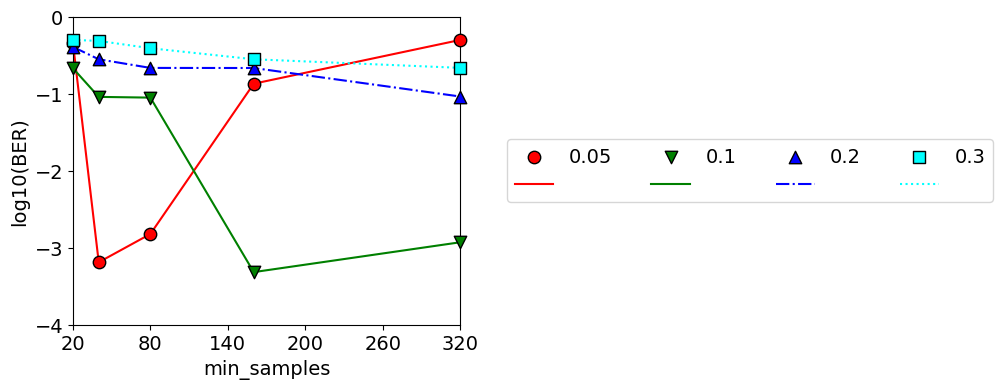

In [64]:
plt.figure(figsize=(5, 4))
eps = [0.05, 0.1, 0.2, 0.3]
for i in range(len(eps)):
    plt.scatter(ber[i]['min_samples'], np.log10(ber[i]['BER']), marker=markers[i], color=colors[i], 
            s=80, edgecolors='black', label=f"{eps[i]}", 
            zorder=3, clip_on=False)
    plt.plot(ber[i]['min_samples'], np.log10(ber[i]['BER']), color=colors[i], label=" ", linestyle=linestyle[i], zorder=2)
plt.xlabel('min_samples', fontsize=14)
plt.ylabel('log10(BER)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([20, 320])
plt.ylim([-4, 0])
plt.xticks(np.linspace(20, 320, 6))
plt.yticks(np.linspace(-4, 0, 5))
plt.legend(bbox_to_anchor=(2.4, 0.5), loc="center right", ncol=4, fontsize=14)

plt.savefig("legend.svg", bbox_inches='tight', pad_inches=0.1, format='svg')
plt.show()